### **Standard lib imports**

In [1]:
import os
from pathlib import Path
os.chdir(Path(os.getcwd()).parent)

In [2]:
from src import config
from src.helper import *

### Load Data

In [3]:
sales = read_data('sales.csv')
sales = sales.sort_values(by=['date', 'product_id'], ).reset_index(drop=True)
sales['date'] = pd.to_datetime(sales['date'])

In [4]:
product_details = read_data('product details.csv')
product_details = product_details.rename({'product_id*31': 'product_id'}, axis=1)

In [5]:
sales.head(10)

,date,product_id,quantity
0,2020-01-02,383408,1
1,2020-01-02,385888,1
2,2020-01-02,409107,1
3,2020-01-02,446989,1
4,2020-01-02,447237,2
5,2020-01-02,452011,1
6,2020-01-02,1903431,1
7,2020-01-02,2013140,2
8,2020-01-02,2078302,1
9,2020-01-02,2108186,3


In [6]:
product_details.head()

,product_id,manufacturer,main_category
0,283509384,Apple,Handy
1,241663414,Tamron,Kameras
2,103621251,ASUSTeKCOMPUTER,Tablets
3,336228170,Libratone,Audio & Hifi
4,330385166,Apple,Laptop


### Basic Analysis of Sales

Let's first look at the plot of daily sales across the year.

In [7]:
sales = sales.set_index('date')

In [8]:
daily, weekly, monthly, quarterly = time_aggregate_data(sales.drop('product_id', axis=1))

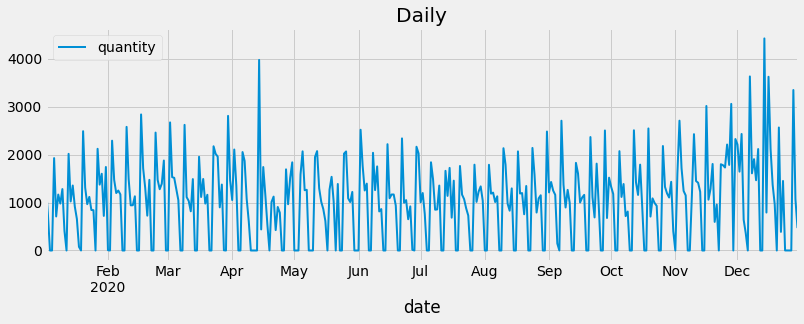

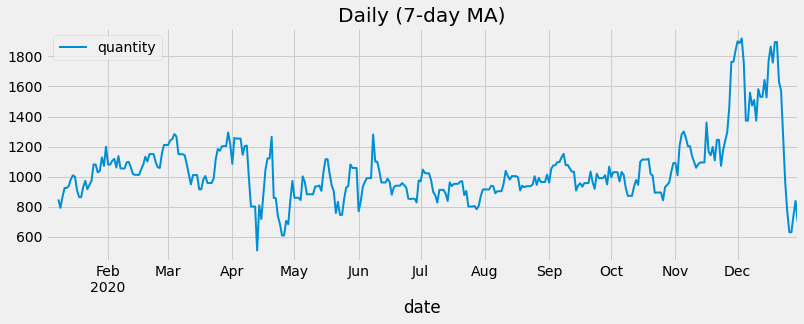

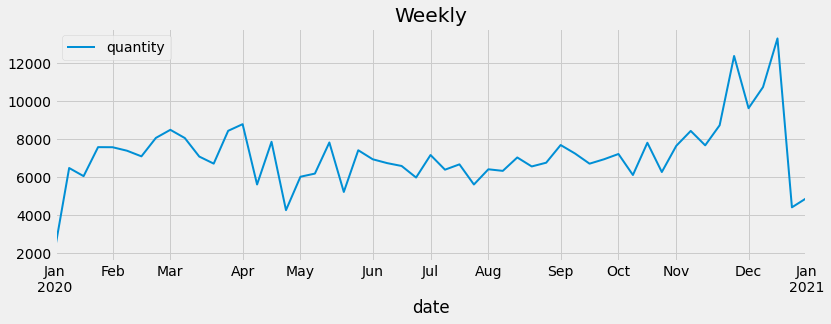

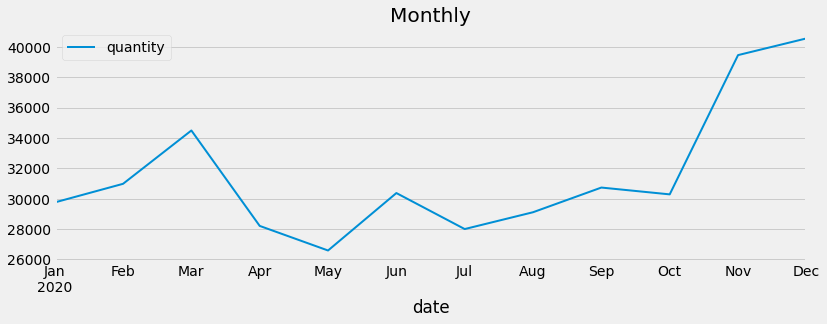

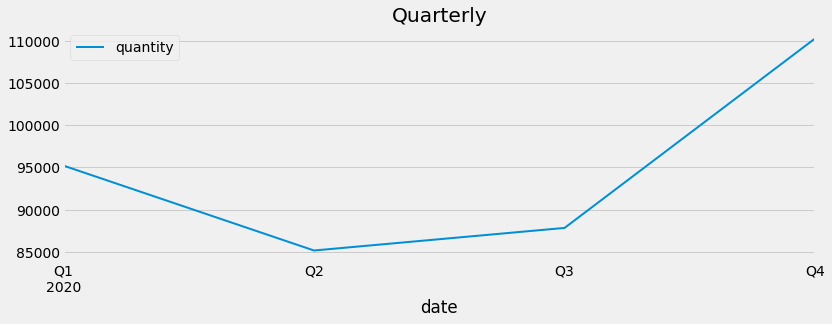

In [9]:
plot_ts_data(sales.drop('product_id', axis=1))

There are a few points to be noted here:
- The highest number of sales occurred in the months of November and December. This can be attributed to Thanksgiving and Christmas (probably)
- There also seems to be a peak of sales in the month of March. 
- The sales drop towards the end of April and in May.

There seems to be some kind of seasonality within each week. Maybe the sales are higher during the weekend than during the week. 
We can decompose the daily sales timeseries.

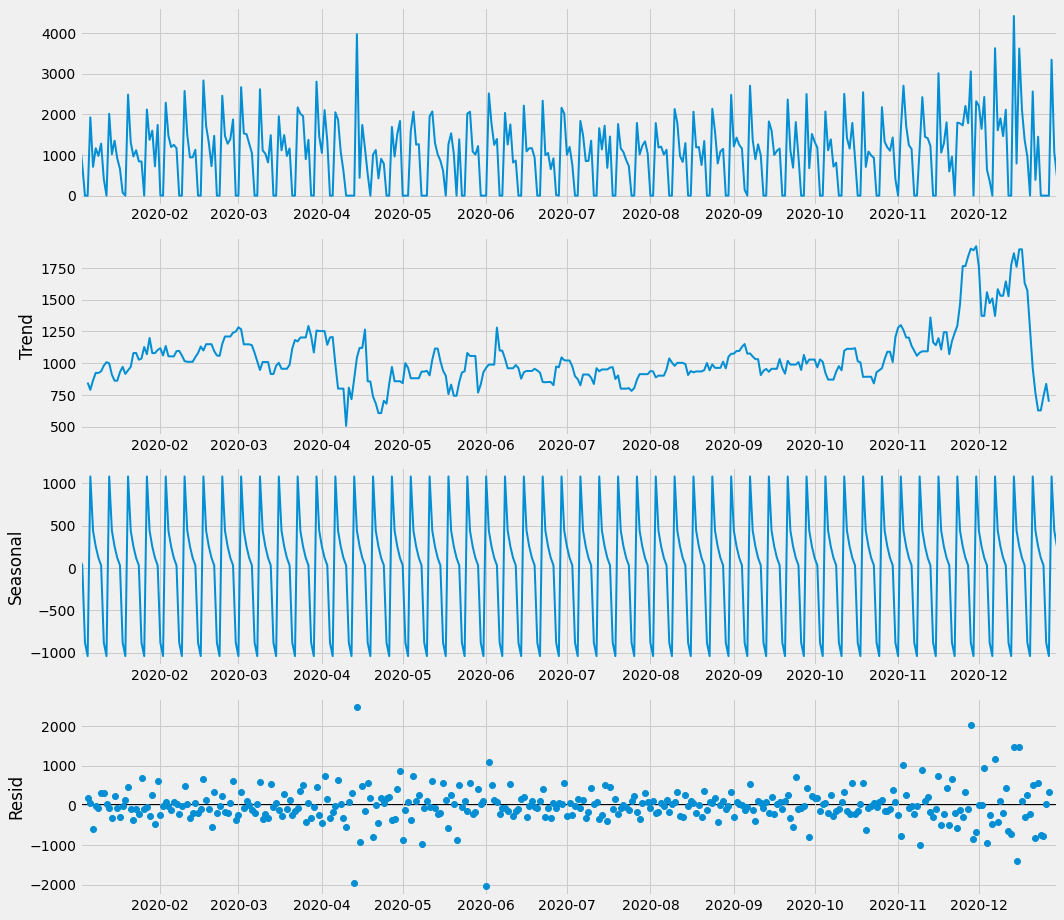

In [10]:
plot_decomposed(daily)

We can clearly see that there is a weekly seasonal component. Let's plot aggregated sales for each day of the week and see what that looks like.

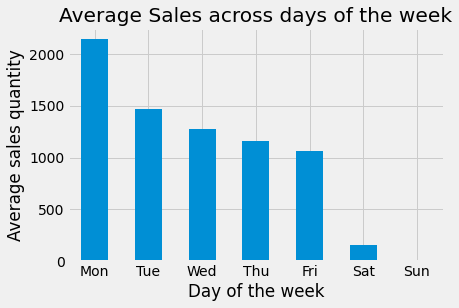

In [11]:
plot_by_day_of_week(daily, title='Average Sales across days of the week', 
                    xlabel='Day of the week', ylabel='Average sales quantity')

Interestingly, the sales have been the highest on Monday and go down through the week. Also, it looks like there are no sales happening on Sunday, which is quite odd. 

**Average number of products sold**

In [13]:
print(f"Average number of products sold per day: {round(daily['quantity'].mean())}")
print(f"Average number of products sold per week: {round(weekly['quantity'].mean())}")
print(f"Average number of products sold per month: {round(monthly['quantity'].mean())}")
print(f"Average number of products sold per month: {round(quarterly['quantity'].mean())}")

Average number of products sold per day: 1040
Average number of products sold per week: 7142
Average number of products sold per month: 31544
Average number of products sold per month: 94631


**Maximum number of products sold in a day**

In [14]:
print(f"Maximum no. of products sold in a day: {daily['quantity'].max()}")
print(f"Date at which this occurred: {daily.index[daily['quantity'].argmax()].date()}")

Maximum no. of products sold in a day: 4419
Date at which this occurred: 2020-12-14


### Top Products, Categories

**Top 10 Products Sold in the year**

In [15]:
n = 10
top_products = sales.groupby('product_id')['quantity'].sum().sort_values(ascending=False).head(n).reset_index()
top_products.merge(product_details, on=['product_id'])

,product_id,quantity,manufacturer,main_category
0,332538023,6663,Apple,Handy
1,332538209,4562,Apple,Handy
2,323343547,3863,Apple,Handy
3,332537930,3774,Apple,Handy
4,332537341,3107,Apple,Handy
5,323343671,2958,Apple,Handy
6,332538271,2928,Apple,Handy
7,323345190,2703,Sony,Konsolen
8,328697836,2629,Samsung,Handy
9,338435897,2592,Samsung,Handy


**Top Product Sold - Monthly**

In [16]:
sales['month'] = sales.index.month

In [17]:
top_prod_monthly = sales.groupby(['month', 'product_id'])['quantity'].sum().reset_index()

In [18]:
top_prod_monthly = top_prod_monthly.groupby('month')[['product_id', 'quantity']]\
    .apply(lambda x: x.sort_values(by='quantity', ascending=False).head(1))\
        .reset_index(level=0).reset_index(drop=True)

In [19]:
top_prod_monthly.merge(product_details, on='product_id').sort_values(by='month')

,month,product_id,quantity,manufacturer,main_category
0,1,332538023,359,Apple,Handy
1,2,332538023,544,Apple,Handy
2,3,332538023,610,Apple,Handy
9,4,323343671,312,Apple,Handy
3,5,332538023,539,Apple,Handy
4,6,332538023,701,Apple,Handy
5,7,332538023,663,Apple,Handy
6,8,332538023,581,Apple,Handy
7,9,332538023,703,Apple,Handy
8,10,332538023,432,Apple,Handy


We observe that in every single month, the highest sold product is by Apple. (In the category of Handy)

**Top 5 Main Categories**

In [20]:
sales_with_cat = sales.merge(product_details, how='left', on='product_id')

In [21]:
sales_with_cat.groupby('main_category')['quantity'].sum().sort_values(ascending=False).head(5).reset_index()

,main_category,quantity
0,Handy,187652
1,Konsolen,54414
2,Tablets,49405
3,Kameras,32174
4,Wearables,18286


The highest selling category is 'Handy'. It's almost 4x as much as the next category (Konsolen)!

**Top 5 Manufacturers**

In [22]:
sales_with_cat.groupby('manufacturer')['quantity'].sum().sort_values(ascending=False).head().reset_index()

,manufacturer,quantity
0,Apple,177281
1,Samsung,64598
2,Sony,37728
3,Huawei,19689
4,Nintendo,18204


Here we see that Apple is by far the largest manufacturer of products being sold on Rebuy.
Putting 2 and 2 together, maybe the largest selling product on Rebuy is the iPhone (since Handy is the highest selling category)